# How to read and examine CETB files

This notebook shows:
* how to open, read, examine and display CETB file data
* how to access EASE-Grid 2.0 projection information and get the map coordinates of the upper left corner
* how to convert CETB dates from "days since epoch" to Gregorian dates
* how to use the cetbtools package to do map transformations for lat/lon to/from row/col

CETB files are available from the globus.org Endpoint "Passive Microwave Prototype ESDR".  Please contact Molly Hardman (molly.hardman_at_nsidc.org) at NSIDC if you have not yet requested an invitation to access the data.

For this notebook, I have downloaded the first 5 days of 2003 CSU N prototype data to my local directory ~/cetb_data/.  If you wish to run this notebook on your local machine, you may have to adjust the paths in the filenames.

## Import required packages for this notebook

Begin by setting up inline matplotlib display, and importing the netCDF4 reader package:


In [1]:
%pylab inline
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
import os
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

Populating the interactive namespace from numpy and matplotlib


/Users/brodzik/miniconda/envs/charistools/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


(You may not see this warning about the font cache on your system, apparently it's new behavior from matplotlib on systems with many fonts installed.)

Next, install and import the cetbtools conda package.  This package contains lat,lon <-> row,col transformation routines for the EASE-Grid 2.0 projections we have used for this project.

You can install the package on your machine using this command in your local conda env:

conda install -c https://conda.anaconda.org/nsidc cetbtools

This package is currently available for python on mac os X and linux platforms.

Assuming you have cetbtools installed, you should be able to do this:

In [2]:
from cetbtools.ease2conv import Ease2Transform

Get help and information about the Ease2Transform class (we will use this class once we have read some data):

In [3]:
help(Ease2Transform)

Help on class Ease2Transform in module cetbtools.ease2conv:

class Ease2Transform
 |  The Ease2Transform class provides map projection conversion routines
 |  for geographic (lat/lon), grid (row/col), and map (x,y) locations in
 |  EASE-Grid 2.0 projections.
 |  
 |  2016-02-27 M. J. Brodzik brodzik@nsidc.org 303-492-8263
 |  National Snow & Ice Data Center, Boulder CO
 |  Copyright (C) 2016 Regents of the University of Colorado at Boulder
 |  
 |  Methods defined here:
 |  
 |  __init__(self, gridname=None, verbose=False)
 |      cetbtools.ease2conv.EASE2Transform(gridname)
 |      
 |      Returns a Transform object for the specified gridname.
 |      
 |      Parameters: gridname : string
 |                      EASE-Grid 2.0 gridname, following the pattern:
 |                      "EASE2-<proj><res>km", where:
 |                      <proj> is "N", "S" or "T"
 |                      <res> is "25", "12.5", "6.25" or "3.125"
 |                  verbose: bool, optional
 |             

## Open a CETB file and examine the TB data:

(You will likely have to change this to the location on your drive where you have downloaded some CETB data):

In [4]:
%cd ~/cetb_data

/Users/brodzik/cetb_data


In [5]:
%ls


F13_CSU_N_2003001/                PMESDRv0.1_F13_CSU_N_2003001.tar
F13_CSU_N_2003002/                PMESDRv0.1_F13_CSU_N_2003002.tar
F13_CSU_N_2003003/                PMESDRv0.1_F13_CSU_N_2003003.tar
F13_CSU_N_2003004/                PMESDRv0.1_F13_CSU_N_2003004.tar
F13_CSU_N_2003005/                PMESDRv0.1_F13_CSU_N_2003005.tar


In [6]:
%cd F13_CSU_N_2003002

/Users/brodzik/cetb_data/F13_CSU_N_2003002


In [7]:
%ls

EASE2_N25km.F13_SSMI.2003002.19H.E.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.19H.M.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.19V.E.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.19V.M.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.22V.E.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.22V.M.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.37H.E.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.37H.M.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.37V.E.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.37V.M.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.85H.E.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.85H.M.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.85V.E.GRD.CSU.v0.1.nc
EASE2_N25km.F13_SSMI.2003002.85V.M.GRD.CSU.v0.1.nc
EASE2_N3.125km.F13_SSMI.2003002.37H.E.BGI.CSU.v0.1.nc
EASE2_N3.125km.F13_SSMI.2003002.37H.E.SIR.CSU.v0.1.nc
EASE2_N3.125km.F13_SSMI.2003002.37H.M.BGI.CSU.v0.1.nc
EASE2_N3.125km.F13_SSMI.2003002.37H.M.SIR.CSU.v0.1.nc
EASE2_N3.125km.F13_SSMI.2003002.37V.E.BGI.CSU.v0.1.nc
EASE2_N3.125km.F

Please refer to the ATBD Appendix to understand filenames:

http://nsidc.org/pmesdr/files/2016/02/MEaSUREs_CETB_ATBD_v0.11.pdf

Choose a file to open, and display the file-level global attributes:

In [8]:
filename = "EASE2_N3.125km.F13_SSMI.2003002.37H.E.SIR.CSU.v0.1.nc"
f = Dataset(filename, "r", format="NETCDF4")
f

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    title: MEaSUREs Calibrated Passive Microwave Daily EASE-Grid 2.0 Brightness Temperature ESDR
    product_version: v0.01
    software_version_id: 0.0.3
    software_repository: git@bitbucket.org:nsidc/measures-byu.git
    source: TBD(list of swath files used)
    source_version_id: TBD(list of GSX versions, 1 per source file)
    history: TBD(bgi or sir command line)
    comment: Prototype version of this product, intended for user evaluation and feedback.
    references: Data set documentation: http://nsidc.org/data/nsidc-0630.html
Algorithm Theoretical Basis Document: http://nsidc.org/pmesdr/files/2015/09/MEaSUREs_CETB_ATBD_v0.10.pdf
Ancillary File: TBD
    summary: An improved, enhanced-resolution, gridded passive microwave Earth System Data Record 
for monitoring cryospheric and hydrologic time series

    institution: National Snow and Ice Data Center
Cooperative Institu

Note that this file contains:
* dimension variables (rows, cols and time) and 
* data variables (crs, TB, TB_num_samples, Incidence_angle, TB_std_dev and TB_time).  

## Get the projection information

The crs variable contains "coordinate reference system" information about the projection and grid used for this file.  To read the crs variable, use:


In [9]:
crs = f.variables['crs']
crs

<type 'netCDF4._netCDF4.Variable'>
|S1 crs()
    grid_mapping_name: lambert_azimuthal_equal_area
    longitude_of_projection_origin: 0.0
    latitude_of_projection_origin: 90.0
    false_easting: 0.0
    false_northing: 0.0
    proj4text: +proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m
    srid: urn:ogc:def:crs:EPSG::6931
    references: ["EASE-Grid 2.0 documentation: http://nsidc.org/data/ease/ease_grid2.html", "Brodzik, Mary J.; Billingsley, Brendan; Haran, Terry; Raup, Bruce; Savoie, Matthew H. 2012.", "EASE-Grid 2.0: Incremental but Significant Improvements for Earth-Gridded Data Sets.", "ISPRS Int. J. Geo-Inf. 1, no. 1: 32-45.", "Brodzik, Mary J.; Billingsley, Brendan; Haran, Terry; Raup, Bruce; Savoie, Matthew H. 2014.", "Correction: Brodzik, M. J., et al. EASE-Grid 2.0: Incremental but Significant Improvements for Earth-Gridded Data Sets.", "ISPRS Int. J. Geo-Inf. 3, no. 3: 1154-1156."]
    crs_wkt: PROJCRS["WGS 84 / NSIDC EASE-Grid 2.0 North", BAS

We have encoded the projection information in several ways in this file, including:

* CF-compliant projection attributes, including grid_mapping_name and specific attributes origin and false easting/northing for the projection
* proj4txt: the proj4 string for this projection
* srid: the EPSG code for this projection
* crs_wkt: the "well-known text" string that describes the projection
* long_name: the NSIDC mapx grid paramater definition name

You can also determine the grid scale factor in meters, from the attribute "scale_factor_at_projection_origin".  

## Get the map coordinates of the UL corner

Finally, if you are looking for the map coordinates (in meters) of the upper left corner of the grid, you can obtain them from the valid_range attributes of the rows and cols dimension variables, like this:


In [10]:
print f.variables['rows'], f.variables['cols']

<type 'netCDF4._netCDF4.Variable'>
float64 rows(rows)
    standard_name: projection_y_coordinate
    units: meters
    axis: Y
    valid_range: [-9000000.  9000000.]
unlimited dimensions: 
current shape = (5760,)
filling on, default _FillValue of 9.96920996839e+36 used
 <type 'netCDF4._netCDF4.Variable'>
float64 cols(cols)
    standard_name: projection_x_coordinate
    units: meters
    axis: X
    valid_range: [-9000000.  9000000.]
unlimited dimensions: 
current shape = (5760,)
filling on, default _FillValue of 9.96920996839e+36 used



The left edge of cols is (in meters) -9000000. and the top edge of rows is 9000000., so the upper left corner of the upper left cell is [row, col] = [9000000., -9000000.]

## Read and display a TB array

The dimension variables cols and rows indicate that this data is a square array that is 5760 x 5760.  To read the 5760x5760 TB array into memory, use:

In [11]:
data = f.variables['TB'][:]
print np.shape(data), np.amin(data), np.amax(data)

(1, 5760, 5760) 112.31 305.04


We have stored each data array with a single time dimension for the date in order to facilitate netCDF tools that allow data across many files to be concatenated by date.  To work just with the 2D array of data, you can use the numpy "squeeze" function like this:

In [12]:
data = np.squeeze(data)
print np.shape(data)

(5760, 5760)


## Get the date of the data in this file

You can get the date of the data in this file by examining the time dimension variable:

In [13]:
d = f.variables['time']
date = d[:]
print d
print date


<type 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: ANSI date
    units: days since 1972-01-01 00:00:00
    calendar: gregorian
    axis: T
    valid_range: [  0.00000000e+000   1.79769313e+308]
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.96920996839e+36 used

[ 11324.]


Note that this date is encoded as "days since 1972-01-01".  To convert to a Gregorian date, use the num2date function imported from the netCDF4 package, and use the strftime function to format it as various date strings:

In [14]:
greg_date = num2date(date[:],units=d.units,calendar=d.calendar)
print(greg_date)
print greg_date[0].strftime("%Y-%m-%d")
print greg_date[0].strftime("%b %d %Y")

[datetime.datetime(2003, 1, 2, 0, 0)]
2003-01-02
Jan 02 2003


## Display the TB array

Next, to display the brightness temperatures in this data array as an image, use imshow:

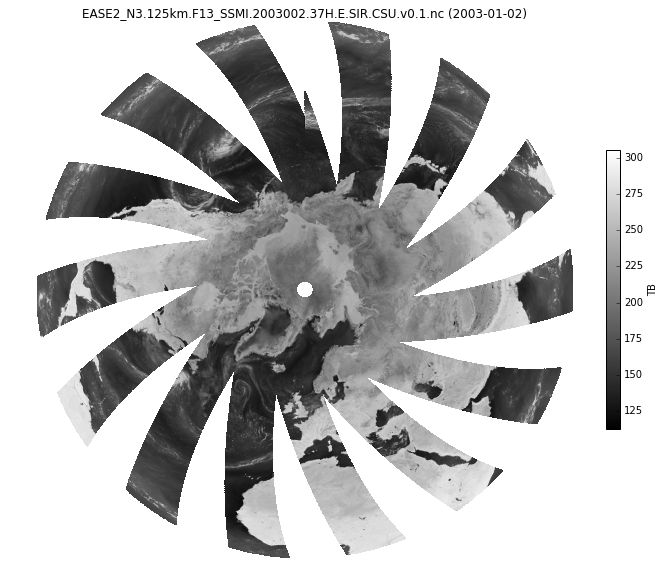

In [15]:
fig, ax = plt.subplots(1,1)
ax.set_title("%s (%s)" % 
             (os.path.basename(filename), greg_date[0].strftime("%Y-%m-%d")))
plt.imshow(data, cmap=plt.cm.gray, vmin=np.amin(data), vmax=np.amax(data), interpolation='nearest')
plt.axis('off')
plt.colorbar(shrink=0.50,label='TB')

## Display the number of measurement samples used for each cell in the image reconstruction

Similarly, the number of samples used to derive each grid cell in the image reconstruction is in the variable TB_num_samples, which can be read and displayed like this:

In [16]:
num = np.squeeze(f.variables['TB_num_samples'][:])

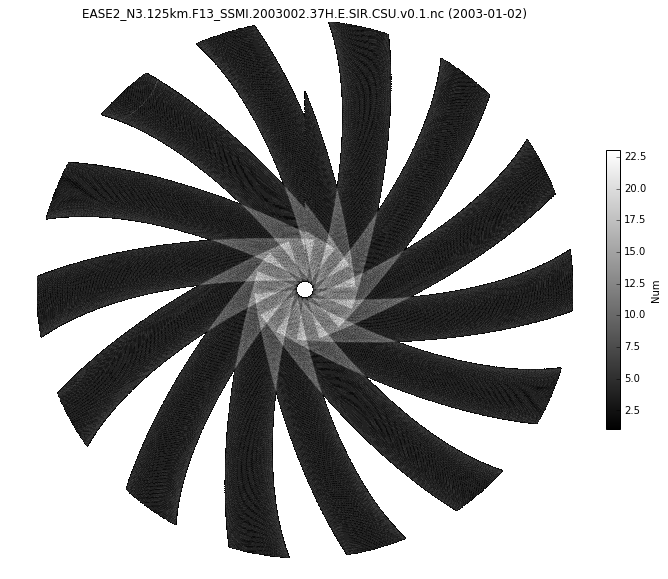

In [17]:
fig, ax = plt.subplots(1,1)
ax.set_title("%s (%s)" % 
             (os.path.basename(filename), greg_date[0].strftime("%Y-%m-%d")))
plt.imshow(num, cmap=plt.cm.gray, vmin=np.amin(num), vmax=np.amax(num), interpolation='nearest')
plt.axis('off')
plt.colorbar(shrink=0.50,label='Num')

## Doing (row,col) <--> (lat, lon) map transformations

To get the TB temperature at a specific geolocation, use the Ease2Transform class.  The initializer for this class need only be called once, and then the "geographic_to_grid" or "grid_to_geographic" methods can be called repeatedly.  The initializer takes one input argument, the NSIDC mapx name for the projection and grid that is stored in the crs.long_name attribute we examined earlier:


In [18]:
print crs.long_name

EASE2_N3.125km


In [19]:
N3grid = Ease2Transform(crs.long_name)

geographic_to_grid can be used to transform a (lat, lon) coordinate to (row, col).  The returned values for row, col will be real-valued, and need to be rounded (up at 0.5) to get the integer values of row, col that can be used to index into the data arrays:

In [20]:
(row, col) = N3grid.geographic_to_grid(40., -105.)
print row, col
(irow, icol) = (int(round(row)), int(round(col)))
print irow, icol

2432.44841081 1211.08075553
2432 1211


In [21]:
print "TB at (40.0N, 105.0W) is: %f K" % data[irow, icol]
print "Num samples used: %d" % num[irow, icol]

TB at (40.0N, 105.0W) is: 253.289993 K
Num samples used: 5


Use grid_to_geographic to transform a (row, col) coordinate to (lat, lon):

In [22]:
print N3grid.grid_to_geographic(row,col)

(39.9999999931616, -104.99999999999999)


Lastly, remember to close the netCDF file:

In [23]:
f.close()

Feel free to contact us with questions about the data or this tutorial: brodzik_at_nsidc.org.